## Name: Rushikesh Sureshkumar Patel
## ID: 1001729170
## Programming Assignment 1 - CSE 6363-004


In [1]:
import numpy as np
from numpy import *

# The function is used to read the data file and store each line in the form of lists
def read_file(filename):
    data = []
    file = open(filename, "r", encoding="utf8")
    for line in file:
        fields = line.rstrip('\n').split(",")
        data.append(fields)
    file.close()
    return data

# The input taken in the form of list 

def compute_distance_between(train_data,test_data,method = "euclidean"):
    if method == "euclidean" :
        # The train and test lits are then type casted to numpy arrays
        train_data = np.asarray(train_data, dtype=np.int64)
        # The class column is not selected from both the test and train
        train_data = train_data[:,:-1]
        test_data = np.asarray(test_data, dtype=np.int64)
        test_data = test_data[:,:-1]
        # Vectorized Computation of Euclidean distance
        distance_matrix = np.sqrt(((test_data**2).sum(axis = 1)[:, None]) + ((train_data**2).sum(axis = 1)) - 2*test_data.dot(train_data.T))
        # The distance_matrix is then converted back to list
        distance_matrix = (distance_matrix).tolist()
        return distance_matrix
        
    elif method == "manhattan":
        train_data = np.asarray(train_data, dtype=np.int64)
        test_data = np.asarray(test_data, dtype=np.int64)
        train_data = train_data[:,:-1]
        test_data = test_data[:,:-1]
        # Vectorized Computation of Manhattan Distance
        distance_matrix = (np.abs(train_data[:,None] - test_data).sum(-1)).T
        distance_matrix = (distance_matrix).tolist()
        return distance_matrix
    
    elif method == "weighted_distance":
        train_data = np.asarray(train_data, dtype=np.int64)
        test_data = np.asarray(test_data, dtype=np.int64)
        train_data = train_data[:,:-1]
        test_data = test_data[:,:-1]
        # First we find the manhattan distance and then 1/each element
        distance_matrix = (np.abs(train_data[:,None] - test_data).sum(-1)).T
        old_settings = np.seterr(divide='ignore')
        distance_matrix = 1/distance_matrix
        # 1/0 raises error thus we replace the infinity with zero as it will help in sorting the neighbors
        is_inf = isinf(distance_matrix)
        distance_matrix[is_inf] = 0
        distance_matrix = (distance_matrix).tolist()
        return distance_matrix
    
    elif method == "cosine_similarity":
        train_data = np.asarray(train_data, dtype=np.int64)
        test_data = np.asarray(test_data, dtype=np.int64)
        train_data = train_data[:,:-1]
        test_data = test_data[:,:-1]
        # Vectorized Computation of Cosine Similarity
        test_data = np.expand_dims(test_data, 1)
        product = np.sum(test_data * train_data, axis = 2)
        norm = np.linalg.norm(test_data, axis=2) * np.linalg.norm(train_data, axis=1)
        distance_matrix = product/norm
        distance_matrix = (distance_matrix).tolist()
        return distance_matrix
        
def find_neighbours(train,test,n = 5,metric = "euclidean"):
    required_neighbours = []
    # Get the distance of all the test data at once
    distance = compute_distance_between(train,test,metric)
    # Finding all the neighbors of the test data points, will be stored in required_neighbors
    for i in range(len(distance)):
        # Empty list create to store neighbors of a single test data point
        all_neighbours = []
        for j in range(len(distance[0])):
            all_neighbours.append([distance[i][j], j])
        # As cosine similarity measures similarity, we reverse order it to get more similar data points
        if metric == "cosine_similarity":
            all_neighbours.sort(reverse = True, key = lambda x:x[0])
        else:
            # For other metrics, lesser the distance more revelant the data points are to each other
            all_neighbours.sort(key = lambda x:x[0])
        test_row =[]
        # Append nearest n neighbors to the test row
        for k in all_neighbours[:n]:
            test_row.append(train[k[1]])
        # Append the whole test_row to the required_neighbors
        required_neighbours.append(test_row)
    return required_neighbours

def predict(train,test,n = 5, metric = "euclidean"):
    # we first get the n nearest neighbors and store it in n_nearest_neighbors 
    n_nearest_neighbours = find_neighbours(train,test, n, metric)
    labels =[]
    # Using the odd values we get the class whose value is maximum
    for i in n_nearest_neighbours:
        neighbour_classes = []
        for j in i:
            neighbour_classes.append(j[-1])
        labels.append(max(neighbour_classes,key=neighbour_classes.count))
    return labels

def compute_accuracy(labels,prediction):
    # Accuracy is obtained using correct_predictions/total_test_data_points
    if len(labels) == len(prediction):
        correct_prediction = 0
        for i in range(len(labels)):
            if labels[i] == prediction[i]:
                correct_prediction += 1
        return correct_prediction/len(labels)
    else:
        print("The number of elements in lables and prediction don't match!")
    

In [2]:
def k_fold(dataframe, k = 10, number_of_neighbours = [x for x in range(30) if x%2!=0], distance_metric = "Euclidean"):
    # Shuffling of the training dataset
    dataframe = dataframe.sample(frac = 1)
    # splits is a list containing each spilts
    splits = np.array_split(dataframe, k )
    # avg_fold_accuracies is a list containting average accuracies of KNN using n Neighbors
    avg_fold_accuracies = []
    for j in number_of_neighbours:
        # All the accuracies of a single K-fold Cross Validation
        accuracies = []
        for i in range(len(splits)):
            # we first assign the test data set 
            # Then get the class labels from it
            test = splits[i]
            test = test.values.tolist()
            class_labels =  [sublist[-1] for sublist in test]
            # Create a temporary variable to store the splits and remove the test dataset form the temp
            temp = splits[:]
            temp.pop(i)
            # Concat the remaining dataset to form training dataset
            train = pd.concat(temp)
            train = train.values.tolist()
            # Pass the train & test dataset to the predict to get the predictions
            predictions = predict(train, test, j, metric = distance_metric)
            # Append the accuracy using the labels and predictions in the accuracies list
            accuracies.append(compute_accuracy(class_labels, predictions))
        # Append the average accuracy to avg_fold_accuracies
        avg_fold_accuracies.append(sum(accuracies)/k)
    return avg_fold_accuracies

In [ ]:
# train_data = read_file("hayes-roth.DATA")
# test_data = read_file("hayes-roth.TEST")
# processed_train_data = [sublist[2:] for sublist in train_data]
# processed_test_data = [sublist[1:] for sublist in test_data]
# class_labels = [sublist[-1] for sublist in test_data]

# Hayes-Roth

In [3]:
import pandas as pd
import numpy as np
# read the hayes-roth.data and add column names to the dataframe
df = pd.read_csv("hayes-roth.data", header = None, names = ["name","hobby","age","educational level","martial status","class"])
df.head(5)

,name,hobby,age,educational level,martial status,class
0,92,2,1,1,2,1
1,10,2,1,3,2,2
2,83,3,1,4,1,3
3,61,2,4,2,2,3
4,107,1,1,3,4,3


In [4]:
df.iloc[:,2:].describe()
# The standard deviation is around 1 so we don't standardize the dataframe

,age,educational level,martial status,class
count,132.000000,132.000000,132.000000,132.000000
mean,1.954545,1.954545,1.954545,1.840909
std,0.947988,0.947988,0.947988,0.769946
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000,1.000000
50%,2.000000,2.000000,2.000000,2.000000
75%,2.000000,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000,3.000000


In [5]:
# Use all the distance_metrics
# For each disatnce_metric we apply K-fold Cross Validation for all the odd numbers till 30
distance_metrics = ["euclidean", "manhattan", "weighted_distance", "cosine_similarity"]
number_of_neighbours = [x for x in range(30) if x%2!=0]
# This list stores the best accuracy attained by a destance_metric
best_metric_accuracies = []
all_accuracies = []
for i in distance_metrics:
    result = k_fold(df.iloc[:,2:],10,number_of_neighbours, distance_metric = i)
    all_accuracies.append(result)
    best_metric_accuracies.append([max(result),number_of_neighbours[result.index(max(result))]])
for j in range(len(distance_metrics)):
    print("For",distance_metrics[j], "the best K-fold accuracy is", best_metric_accuracies[j][0],"using",best_metric_accuracies[j][1],"nearest neighbours.")

For euclidean the best K-fold accuracy is 0.8098901098901099 using 3 nearest neighbours.
For manhattan the best K-fold accuracy is 0.7956043956043956 using 1 nearest neighbours.
For weighted_distance the best K-fold accuracy is 0.7879120879120879 using 1 nearest neighbours.
For cosine_similarity the best K-fold accuracy is 0.6362637362637361 using 3 nearest neighbours.


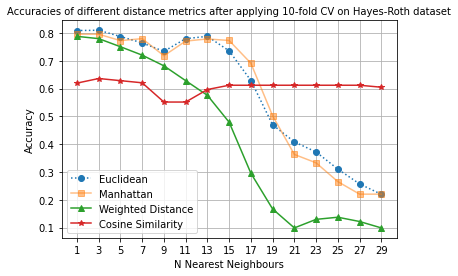

In [6]:
import matplotlib.pyplot as plt
x1 = list(range(len(number_of_neighbours)))
plt.plot(x1, all_accuracies[0], marker = "o", label = "Euclidean", linestyle = ":")
plt.plot(x1, all_accuracies[1], marker = "s",  label = "Manhattan", alpha = 0.5)
plt.plot(x1, all_accuracies[2], marker = "^", label = "Weighted Distance")
plt.plot(x1, all_accuracies[3], marker = "*", label = "Cosine Similarity")
plt.xlabel("N Nearest Neighbours")
plt.ylabel("Accuracy")
plt.xticks(ticks = x1,labels = number_of_neighbours)
plt.title("Accuracies of different distance metrics after applying 10-fold CV on Hayes-Roth dataset",fontsize = 10)
plt.grid(b = True)
# plt.tight_layout()
plt.legend()
plt.savefig("Comparison-Hayes-Roth.png", bbox_inches='tight')
plt.show()

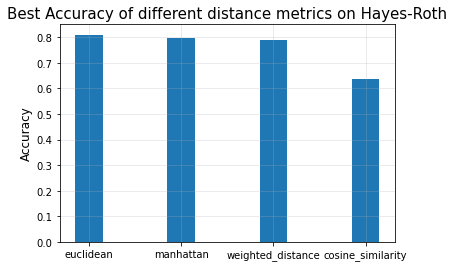

In [7]:
def get_accuracy_from_list(any_list):
    return [i[0] for i in any_list]

# import matplotlib.pyplot as plt
%matplotlib inline
y = get_accuracy_from_list(best_metric_accuracies)
x = np.arange(4)
plt.bar(x, height=y, width = 0.3)
plt.xticks(x, distance_metrics)
plt.title("Best Accuracy of different distance metrics on Hayes-Roth", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 12)
plt.grid(alpha = 0.3)
plt.savefig("Best-Accuracies-Hayes-Roth.png", bbox_inches='tight')
plt.show()


In [ ]:
# number_of_neighbours = [x for x in range(30) if x%2!=0]
# k_fold_accuracy = k_fold(df.iloc[:,2:],10,number_of_neighbours)
# print("The best accuracy is:",max(k_fold_accuracy))
# print("Corresponding k value is:",number_of_neighbours[k_fold_accuracy.index(max(k_fold_accuracy))])

# Car Evaluation Data Set
https://stackoverflow.com/questions/32011359/convert-categorical-data-in-pandas-dataframe/32011969

In [8]:
# Read the DATA file and load the Dataframe
df1 = pd.read_csv("car.data", header = None, names = ["buying","maint","doors","persons","lug_boot","safety","class"])
df1.head(5)

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [9]:
# We see the data types of the attribute values
df1.dtypes

buying      object
maint       object
doors       object
persons     object
lug_boot    object
safety      object
class       object
dtype: object

In [10]:
# To perform KNN we must convert the object data type to nominal type
# First, we convert each features into a categorical type

df1['buying'] = df1['buying'].astype('category')
df1['maint'] = df1['maint'].astype('category')
df1['doors'] = df1['doors'].astype('category')
df1['persons'] = df1['persons'].astype('category')
df1['lug_boot'] = df1['lug_boot'].astype('category')
df1['safety'] = df1['safety'].astype('category')
df1['class'] = df1['class'].astype('category')

In [11]:
df1.dtypes

buying      category
maint       category
doors       category
persons     category
lug_boot    category
safety      category
class       category
dtype: object

In [12]:
# Then, we make use of Pandas .cat.codes to convert each columns(categorical) into nominal values
cat_columns = df1.select_dtypes(['category']).columns
df1[cat_columns] = df1[cat_columns].apply(lambda x: x.cat.codes)
df1.head(5)

,buying,maint,doors,persons,lug_boot,safety,class
0,3,3,0,0,2,1,2
1,3,3,0,0,2,2,2
2,3,3,0,0,2,0,2
3,3,3,0,0,1,1,2
4,3,3,0,0,1,2,2


In [13]:
df1.describe()

,buying,maint,doors,persons,lug_boot,safety,class
count,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000,1728.000000
mean,1.500000,1.500000,1.500000,1.000000,1.000000,1.000000,1.553241
std,1.118358,1.118358,1.118358,0.816733,0.816733,0.816733,0.875948
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.750000,0.750000,0.750000,0.000000,0.000000,0.000000,1.000000
50%,1.500000,1.500000,1.500000,1.000000,1.000000,1.000000,2.000000
75%,2.250000,2.250000,2.250000,2.000000,2.000000,2.000000,2.000000
max,3.000000,3.000000,3.000000,2.000000,2.000000,2.000000,3.000000


In [14]:
df1.to_csv("Car-processsed-data.csv",index = False)

In [ ]:
# As the pre-processing is done, we now perform K-fold Cross validation (K = 10)
# k_fold_accuracy1 = k_fold(df1,10,number_of_neighbours)
# print("The best accuracy is:",max(k_fold_accuracy1))
# print("Corresponding k value is:",number_of_neighbours[k_fold_accuracy1.index(max(k_fold_accuracy1))])

In [15]:
# distance_metrics = ["euclidean", "manhattan", "weighted_distance", "cosine_similarity"]
# number_of_neighbours = [x for x in range(30) if x%2!=0]
metric_based_accuracies1 = []
all_accuracies1 = []
for i in distance_metrics:
    result1 = k_fold(df1,10,number_of_neighbours, distance_metric = i)
    all_accuracies1.append(result1)
    metric_based_accuracies1.append([max(result1),number_of_neighbours[result1.index(max(result1))]])
for j in range(len(distance_metrics)):
    print("For",distance_metrics[j], "the best K-fold accuracy is", metric_based_accuracies1[j][0],"using",metric_based_accuracies1[j][1],"nearest neighbours.")

C:\Users\Itachi\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


For euclidean the best K-fold accuracy is 0.9340133082403549 using 7 nearest neighbours.
For manhattan the best K-fold accuracy is 0.9444313751848368 using 7 nearest neighbours.
For weighted_distance the best K-fold accuracy is 0.6527859927409598 using 29 nearest neighbours.
For cosine_similarity the best K-fold accuracy is 0.855293050141148 using 7 nearest neighbours.


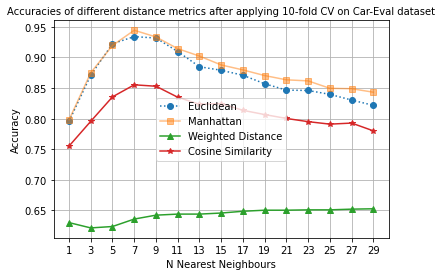

In [16]:
x2 = list(range(len(number_of_neighbours)))
plt.plot(x2, all_accuracies1[0], marker = "o", label = "Euclidean", linestyle = ":")
plt.plot(x2, all_accuracies1[1], marker = "s",  label = "Manhattan", alpha = 0.5)
plt.plot(x2, all_accuracies1[2], marker = "^", label = "Weighted Distance")
plt.plot(x2, all_accuracies1[3], marker = "*", label = "Cosine Similarity")
plt.xlabel("N Nearest Neighbours")
plt.ylabel("Accuracy")
plt.xticks(ticks = x2,labels = number_of_neighbours)
plt.title("Accuracies of different distance metrics after applying 10-fold CV on Car-Eval dataset",fontsize = 10)
plt.grid(b = True)
# plt.tight_layout()
plt.legend()
plt.savefig("Comparison-Car-Dataset.png", bbox_inches='tight')
plt.show()

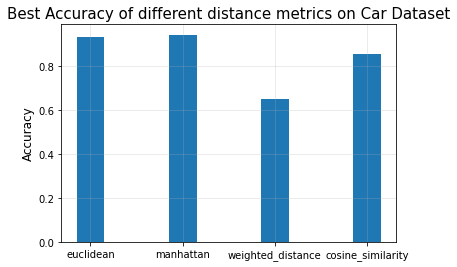

In [17]:
z = get_accuracy_from_list(metric_based_accuracies1)
# x = np.arange(4)
plt.bar(x, height=z,width = 0.3)
plt.xticks(x, distance_metrics)
plt.title("Best Accuracy of different distance metrics on Car Dataset", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 12)
plt.grid(alpha = 0.3)
plt.savefig("Best-Accuracies-Car-Dataset.png", bbox_inches='tight')
plt.show()

# Breast-Cancer Dataset

In [18]:
# Read the DATA file and load the Dataframe
df2 = pd.read_csv("breast-cancer.data", header = None, 
                  names = ["Class","age","menopause","tumor-size","inv-nodes","node-caps","deg-malig","breast","breast-quad","irradiat"])
df2.head(5)

,Class,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat
0,no-recurrence-events,30-39,premeno,30-34,0-2,no,3,left,left_low,no
1,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,right,right_up,no
2,no-recurrence-events,40-49,premeno,20-24,0-2,no,2,left,left_low,no
3,no-recurrence-events,60-69,ge40,15-19,0-2,no,2,right,left_up,no
4,no-recurrence-events,40-49,premeno,0-4,0-2,no,2,right,right_low,no


In [19]:
# We move the "Class" column to last 
df2 = df2[["age","menopause","tumor-size","inv-nodes","node-caps","deg-malig","breast","breast-quad","irradiat","Class"]]
df2.head(5)

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,30-39,premeno,30-34,0-2,no,3,left,left_low,no,no-recurrence-events
1,40-49,premeno,20-24,0-2,no,2,right,right_up,no,no-recurrence-events
2,40-49,premeno,20-24,0-2,no,2,left,left_low,no,no-recurrence-events
3,60-69,ge40,15-19,0-2,no,2,right,left_up,no,no-recurrence-events
4,40-49,premeno,0-4,0-2,no,2,right,right_low,no,no-recurrence-events


In [20]:
# Again just like on previous data-set of Car we convert the object data types of the columns to nominal data type  
df2.dtypes

age            object
menopause      object
tumor-size     object
inv-nodes      object
node-caps      object
deg-malig       int64
breast         object
breast-quad    object
irradiat       object
Class          object
dtype: object

In [21]:
df2['age'] = df2['age'].astype('category')
df2['menopause'] = df2['menopause'].astype('category')
df2['tumor-size'] = df2['tumor-size'].astype('category')
df2['inv-nodes'] = df2['inv-nodes'].astype('category')
df2['node-caps'] = df2['node-caps'].astype('category')
df2['breast'] = df2['breast'].astype('category')
df2['breast-quad'] = df2['breast-quad'].astype('category')
df2['irradiat'] = df2['irradiat'].astype('category')
df2['Class'] = df2['Class'].astype('category')
cat_columns1 = df2.select_dtypes(['category']).columns
df2[cat_columns1] = df2[cat_columns1].apply(lambda x: x.cat.codes)
df2.head(5)

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,1,2,5,0,1,3,0,2,0,0
1,2,2,3,0,1,2,1,5,0,0
2,2,2,3,0,1,2,0,2,0,0
3,4,0,2,0,1,2,1,3,0,0
4,2,2,0,0,1,2,1,4,0,0


In [22]:
df2.describe()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
count,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000,286.000000
mean,2.664336,1.073427,4.062937,1.073427,1.167832,2.048951,0.468531,2.772727,0.237762,0.297203
std,1.011818,0.986680,2.151187,1.935321,0.443052,0.738217,0.499883,1.099006,0.426459,0.457828
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,3.000000,0.000000,1.000000,2.000000,0.000000,2.000000,0.000000,0.000000
50%,3.000000,2.000000,4.000000,0.000000,1.000000,2.000000,0.000000,3.000000,0.000000,0.000000
75%,3.000000,2.000000,5.000000,1.000000,1.000000,3.000000,1.000000,3.000000,0.000000,1.000000
max,5.000000,2.000000,10.000000,6.000000,2.000000,3.000000,1.000000,5.000000,1.000000,1.000000


In [23]:
# Exporting the csv file for using it in Weka
df2.to_csv("Breast-Cancer-processsed-data.csv",index = False)

In [ ]:
# As the pre-processing is done, we now perform K-fold Cross validation (K = 10)
# k_fold_accuracy2 = k_fold(df2,10,number_of_neighbours)
# print("The best accuracy is:",max(k_fold_accuracy2))
# print("Corresponding k value is:",number_of_neighbours[k_fold_accuracy2.index(max(k_fold_accuracy2))])

In [24]:
metric_based_accuracies2 = []
all_accuracies2 = []
for i in distance_metrics:
    result2 = k_fold(df2,10,number_of_neighbours, distance_metric = i)
    all_accuracies2.append(result2)
    metric_based_accuracies2.append([max(result2),number_of_neighbours[result2.index(max(result2))]])
for j in range(len(distance_metrics)):
    print("For",distance_metrics[j], "the best K-fold accuracy is", metric_based_accuracies2[j][0],"using",metric_based_accuracies2[j][1],"nearest neighbours.")

For euclidean the best K-fold accuracy is 0.7242610837438423 using 19 nearest neighbours.
For manhattan the best K-fold accuracy is 0.744704433497537 using 23 nearest neighbours.
For weighted_distance the best K-fold accuracy is 0.4688423645320198 using 29 nearest neighbours.
For cosine_similarity the best K-fold accuracy is 0.7206896551724138 using 23 nearest neighbours.


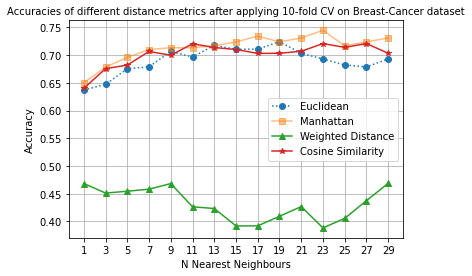

In [25]:
x3 = list(range(len(number_of_neighbours)))
plt.plot(x3, all_accuracies2[0], marker = "o", label = "Euclidean", linestyle = ":")
plt.plot(x3, all_accuracies2[1], marker = "s",  label = "Manhattan", alpha = 0.5)
plt.plot(x3, all_accuracies2[2], marker = "^", label = "Weighted Distance")
plt.plot(x3, all_accuracies2[3], marker = "*", label = "Cosine Similarity")
plt.xlabel("N Nearest Neighbours")
plt.ylabel("Accuracy")
plt.xticks(ticks = x3,labels = number_of_neighbours)
plt.title("Accuracies of different distance metrics after applying 10-fold CV on Breast-Cancer dataset",fontsize = 10)
plt.grid(b = True)
# plt.tight_layout()
plt.legend()
plt.savefig("Comparison-Breast-Cancer.png", bbox_inches='tight')
plt.show()

## Creating Graphs to display the accuracy of Weka vs My Implementation

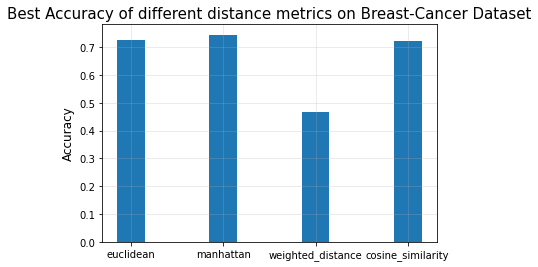

In [26]:
a = get_accuracy_from_list(metric_based_accuracies2)
# x = np.arange(4)
plt.bar(x, height=a, width = 0.3)
plt.xticks(x, distance_metrics)
plt.title("Best Accuracy of different distance metrics on Breast-Cancer Dataset", fontsize = 15)
plt.ylabel("Accuracy", fontsize = 12)
plt.grid(alpha = 0.3)
plt.savefig("Best-Accuracies-Breast-Cancer.png", bbox_inches='tight')
plt.show()

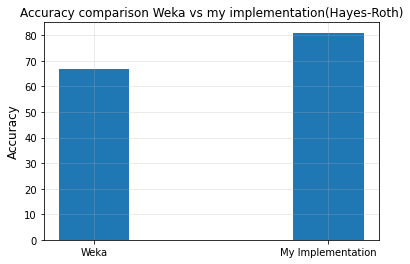

In [30]:
# Weka Comparison
hayes_roth =[66.6667, 80.9890]
weka_range = np.arange(2)
plt.bar(weka_range, hayes_roth, width = 0.3)
plt.xticks(weka_range, ("Weka","My Implementation"))
plt.title("Accuracy comparison Weka vs my implementation(Hayes-Roth)")
plt.ylabel("Accuracy", fontsize = 12)
plt.grid(alpha = 0.3)
plt.savefig("Comparison-Weka-Hayes-Roth.png", bbox_inches='tight')
plt.show()

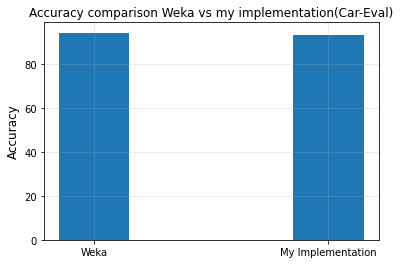

In [31]:
car_eval =[94.4444, 93.4013]
# weka_range = np.arange(2)
plt.bar(weka_range, car_eval, width = 0.3)
plt.xticks(weka_range, ("Weka","My Implementation"))
plt.title("Accuracy comparison Weka vs my implementation(Car-Eval)")
plt.ylabel("Accuracy", fontsize = 12)
plt.grid(alpha = 0.3)
plt.savefig("Comparison-Weka-Car-Eval.png", bbox_inches='tight')
plt.show()

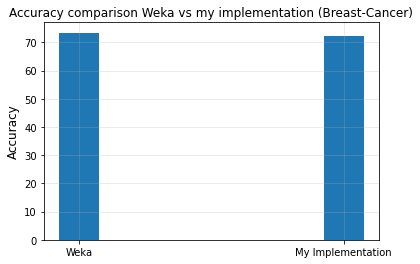

In [35]:
breast_cancer =[73.4266, 72.4261]
# weka_range = np.arange(2)
plt.bar(weka_range, breast_cancer, width = 0.3)
plt.xticks(weka_range, ("Weka","My Implementation"))
plt.title("Accuracy comparison Weka vs my implementation (Breast-Cancer)")
plt.ylabel("Accuracy", fontsize = 12)
plt.grid(alpha = 0.3)
plt.savefig("Comparison-Weka-Breast-Cancer.png", bbox_inches='tight')
plt.show()